Let's look at the latest database of Gamma Ray Bursts.

- The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
- You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html
T
his edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. Be creative! You're discovering

Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed?

In [91]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from astropy import coordinates as coord
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from sklearn.neighbors import KernelDensity

In [92]:
# Download file
#r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
#with open("Summary_table.txt", 'wb') as f:
#    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str', unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

# Check the data
print("Data names: ", names)
print("Data shape: ", data.shape)

Data names:  ['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']
Data shape:  (15, 8721)


In [93]:
# Extract the variable 
ra = data[names=='ra'][0].astype(float) # Right Ascension
decl = data[names=='decl'][0].astype(float) # Declination

T90 = data[names=='T90'][0].astype(float)
T90_error = data[names=='T90_error'][0].astype(float)

fluence = data[names=='fluence'][0].astype(float)
fluence_error = data[names=='fluence_error'][0].astype(float)

redshift = data[names=='redshift'][0].astype(float)

mjd_T0 = data[names=='mjd_(T0)'][0].astype(float)

T100 = data[names=="'T100'"][0].astype(float)

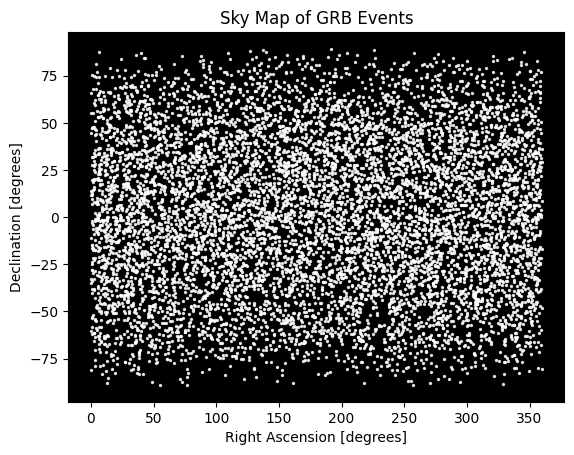

In [94]:
# Sky Map
plt.scatter(ra, decl, color='white', s=2, alpha=0.8)
plt.gca().set_facecolor('black')
plt.xlabel('Right Ascension [degrees]')
plt.ylabel('Declination [degrees]')
plt.title('Sky Map of GRB Events')
plt.show()

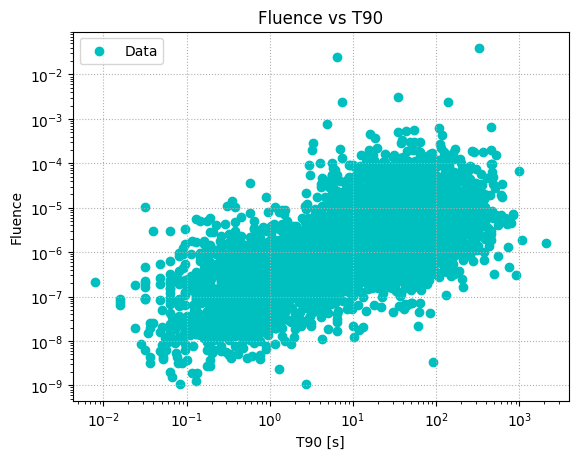

In [ ]:
# Plot T90-Fluence

# Mask to remove unphysical values
mask = (T90 != -999) & (fluence != -999)

T90_corr = T90[mask]
fluence_corr = fluence[mask]

plt.scatter(T90_corr, fluence_corr, color='c', label='Data')
plt.xscale('log')
plt.yscale('log')
plt.title('Fluence vs T90')
plt.xlabel('T90 [s]')
plt.ylabel('Fluence')
plt.grid(linestyle=':')
plt.legend()
plt.show()


## 1-D Distribution

In [ ]:
# Select the data and remove unphysical values
T90_s1 = T90[T90 > 0]

fluence_s1 = fluence[fluence > 0]

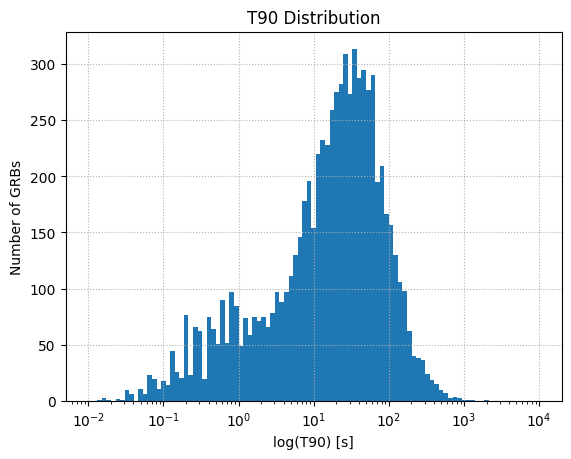

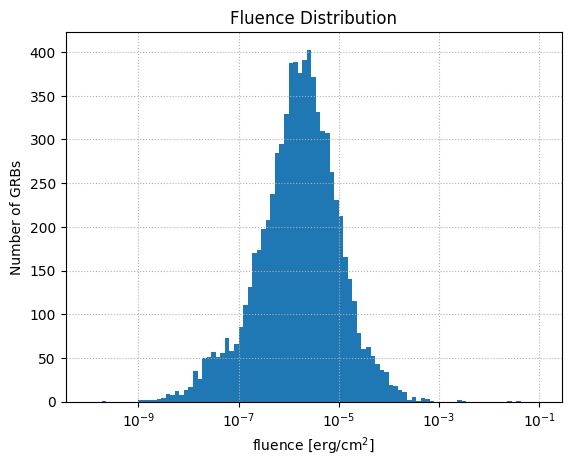

In [130]:
# Histogram for T90 (semi-log scale)
plt.hist(T90_s1, bins=np.logspace(-2, 4, 100))
plt.xscale('log')
plt.title('T90 Distribution')
plt.xlabel('log(T90) [s]')
plt.ylabel('Number of GRBs')
plt.grid(linestyle=':')
plt.show()

# Histogram for fluence (semi-log scale)
plt.hist(fluence_s1, bins=np.logspace(-10, -1, 100))
plt.xscale('log')
plt.title('Fluence Distribution')
plt.xlabel(f'fluence [erg/cm$^2$]')
plt.ylabel('Number of GRBs')
plt.grid(linestyle=':')
plt.show()

### KDE

### Clustering

## 2-D Distribution

### Clustering

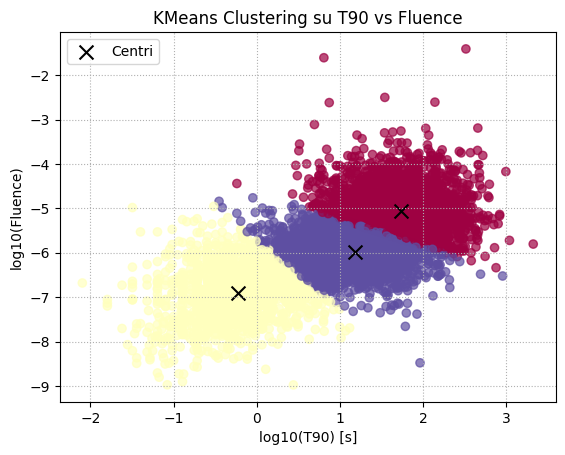

In [111]:
idx_T90 = np.where(names == 'T90')[0][0]
idx_fluence = np.where(names == 'fluence')[0][0]

mask = (T90 > 0) & (fluence > 0)
X = np.vstack([np.log10(T90[mask]), np.log10(fluence[mask])]).T

# KMeans clustering
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=0)
labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

# Plot
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='Spectral', alpha=0.7)
plt.scatter(centers[:, 0], centers[:, 1], c='k', s=100, marker='x', label='Centri')
plt.xlabel('log10(T90) [s]')
plt.ylabel('log10(Fluence)')
plt.title('KMeans Clustering su T90 vs Fluence')
plt.legend()
plt.grid(linestyle=':')
plt.show()

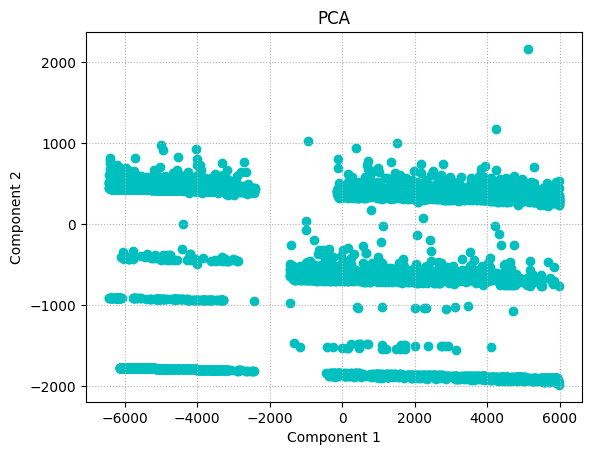

In [112]:
# PCA

pca = PCA(n_components=2) # 2 components
reduced_data= pca.fit_transform(formatted_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='c')
plt.title('PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(linestyle=':')
plt.show()

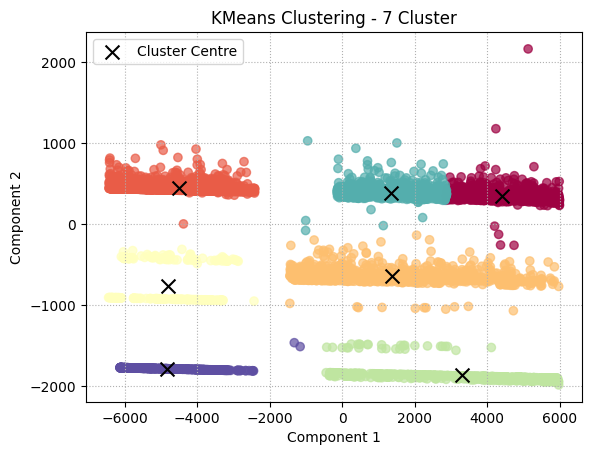

In [113]:
# KMeans Clustering
scaler = StandardScaler()
reduced_data_scaled = scaler.fit_transform(reduced_data)

n_clusters = 7
clf = KMeans(n_clusters=n_clusters, n_init='auto')
clf.fit(reduced_data_scaled)

centers = scaler.inverse_transform(clf.cluster_centers_)
labels = clf.labels_

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='Spectral', alpha=0.7)
plt.scatter(centers[:, 0], centers[:, 1], c='k', marker='x', s=100, label='Cluster Centre')
plt.title(f'KMeans Clustering - {n_clusters} Cluster')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(linestyle=':')
plt.show()

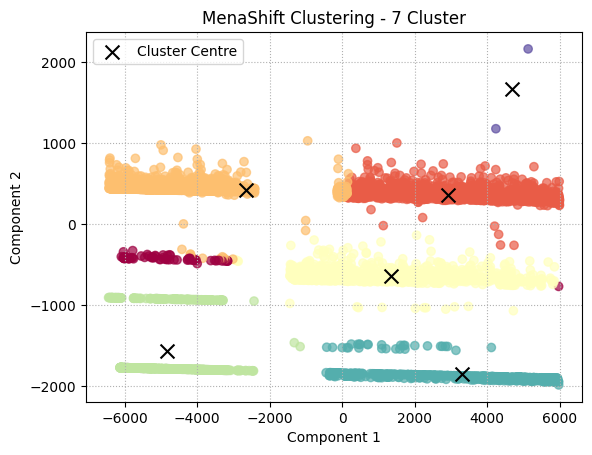

In [114]:
# MeanShift clustering
scaler = StandardScaler()
reduced_data_scaled = scaler.fit_transform(reduced_data)

bandwidth = estimate_bandwidth(reduced_data_scaled, quantile=0.3, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
ms.fit(reduced_data_scaled) 

labels = ms.labels_
n_clusters = len(set(labels))  
centers = scaler.inverse_transform(ms.cluster_centers_)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='Spectral', alpha=0.7)
plt.scatter(centers[:, 0], centers[:, 1], c='k', marker='x', s=100, label='Cluster Centre')
plt.title(f'MenaShift Clustering - {n_clusters} Cluster')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(linestyle=':')
plt.show()